In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [2]:
with open("../0 save inner data/1 read all HPLC.pkl",'rb') as f:
    sources, dates, lon, lat, depth, pigments = pickle.load(f)

for var in pigments: print(var,len(pigments[var]),type(pigments[var][0]),end="\t")

fuco 86327 <class 'numpy.float64'>	perid 86327 <class 'numpy.float64'>	hex_fuco 86327 <class 'numpy.float64'>	but_fuco 86327 <class 'numpy.float64'>	allo 86327 <class 'numpy.float64'>	tchl_b 86327 <class 'numpy.float64'>	zea 86327 <class 'numpy.float64'>	tchl_a 86327 <class 'numpy.float64'>	dv_chl_a 86327 <class 'numpy.float64'>	

# 开始整理数据，去除异常

In [3]:
use_num = len(lat)

use_pigments = {}
for var in pigments:
    use_pigments[var] = np.ones_like(lat,dtype=bool)

## 1 去除nan数据，保证参数均为数字

In [4]:
for var in pigments:
    use = ~np.isnan(pigments[var])
    use_pigments[var] = use_pigments[var] & use
    print(var,sum(use),end="\t\t\t")


fuco 83470			perid 79233			hex_fuco 82386			but_fuco 80683			allo 75500			tchl_b 62440			zea 77160			tchl_a 76097			dv_chl_a 46400			

## 2 去除提取程序中未删除的异常数据

In [5]:
for var in pigments: 
    use = (pigments[var]<50)&(pigments[var]>=0)
    use_pigments[var] = use_pigments[var] & use
    print(var,sum(use),end="\t\t\t")

# pigments["chl_a"][pigments["chl_a"]>pigments["tchl_a"]] = False

fuco 83456			perid 79137			hex_fuco 82304			but_fuco 80458			allo 75413			tchl_b 61736			zea 77152			tchl_a 75918			dv_chl_a 45693			

## 4 choose depth,tchla

In [6]:
# depth
depth10 = (depth <= 300)
for var in use_pigments: 
    use_pigments[var] = use_pigments[var] & depth10


# tchl_a
# tchla_out_range = (pigments["tchl_a"] > 30.0)&(pigments["tchl_a"] < 0.005)
# tchla_not_out_range = ~tchla_out_range
tchla_in_range = (pigments["tchl_a"] < 30.0)&(pigments["tchl_a"] >= 0.005)

# abnormal chla in depth
# abnormal = ((depth>40)&(pigments["tchl_a"]>5))|((depth>100)&(pigments["tchl_a"]>1))
# abnormal = abnormal|((depth>100)&(pigments["fuco"]>0.05))
# abnormal = abnormal|((depth>100)&(pigments["perid"]>0.02))
# abnormal = abnormal|((depth>100)&(pigments["zea"]>0.1))

for var in use_pigments:
    pigment_range = (pigments[var]<=30.0)&(pigments[var]>=0.001)
    use_pigments[var] = use_pigments[var] & tchla_in_range & pigment_range
    use_pigments[var] = use_pigments[var] & (pigments["tchl_a"]>=pigments[var])


In [7]:
# abnormal = np.zeros_like(depth,dtype=bool)
# for dep in [[50,99],[99,101],[101,149],[149,151],[151,300]]:
#     for item in pigments:
#         tmp_pigments = pigments[item][(depth>dep[0])&(depth<=dep[1])]
#         tmp_pigments = tmp_pigments[~np.isnan(tmp_pigments)]
#         thre = np.sort(tmp_pigments)[round(len(tmp_pigments)*0.95)]
#         cho = (pigments[item]>thre)&(depth>dep[0])&(depth<=dep[1])
#         abnormal = cho | abnormal
        
# for var in use_pigments:
#     use_pigments[var] = use_pigments[var] & (~abnormal)

In [8]:
for var in use_pigments:
    print(var,use_pigments[var].shape,use_pigments[var].sum(),end="\t")

fuco (86327,) 68083	perid (86327,) 49425	hex_fuco (86327,) 70129	but_fuco (86327,) 66624	allo (86327,) 42558	tchl_b (86327,) 49764	zea (86327,) 57693	tchl_a (86327,) 73964	dv_chl_a (86327,) 27775	

# save data

In [9]:
with open("../0 save inner data/2 sorted_pigments_all.pkl", 'wb') as f:
    pickle.dump([sources, dates, lon, lat, depth, pigments, use_pigments], f)

In [10]:
with open("../0 save inner data/match data.pkl", 'wb') as f:
    pickle.dump([np.array(dates), np.round(np.array(lon),3), np.round(np.array(lat),3)], f)

In [11]:
with open("../0 save inner data/match data (3D).pkl", 'wb') as f:
    pickle.dump([np.array(dates), np.round(np.array(lon),3), np.round(np.array(lat),3),np.round(np.array(depth),3)], f)

# show some result

Text(0, 0.5, 'count')

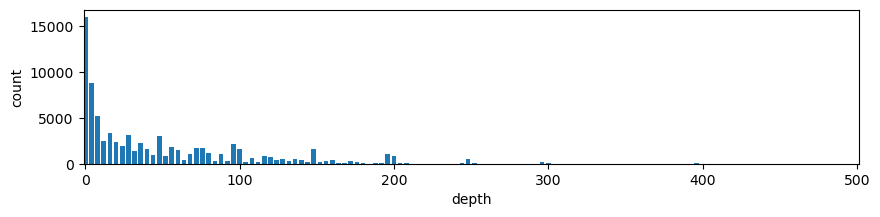

In [12]:
dep = np.array(depth)
count = []
for i in np.arange(0,500,4):
    count.append((dep<=i).sum())
count = np.array(count)

plt.figure(figsize=(10,2))
plt.bar(np.arange(0,500,4)[:-1],count[1:]-count[:-1],width=3)
plt.xlim(-1,501)
# plt.ylim(0,1000)
plt.xlabel("depth")
plt.ylabel("count")

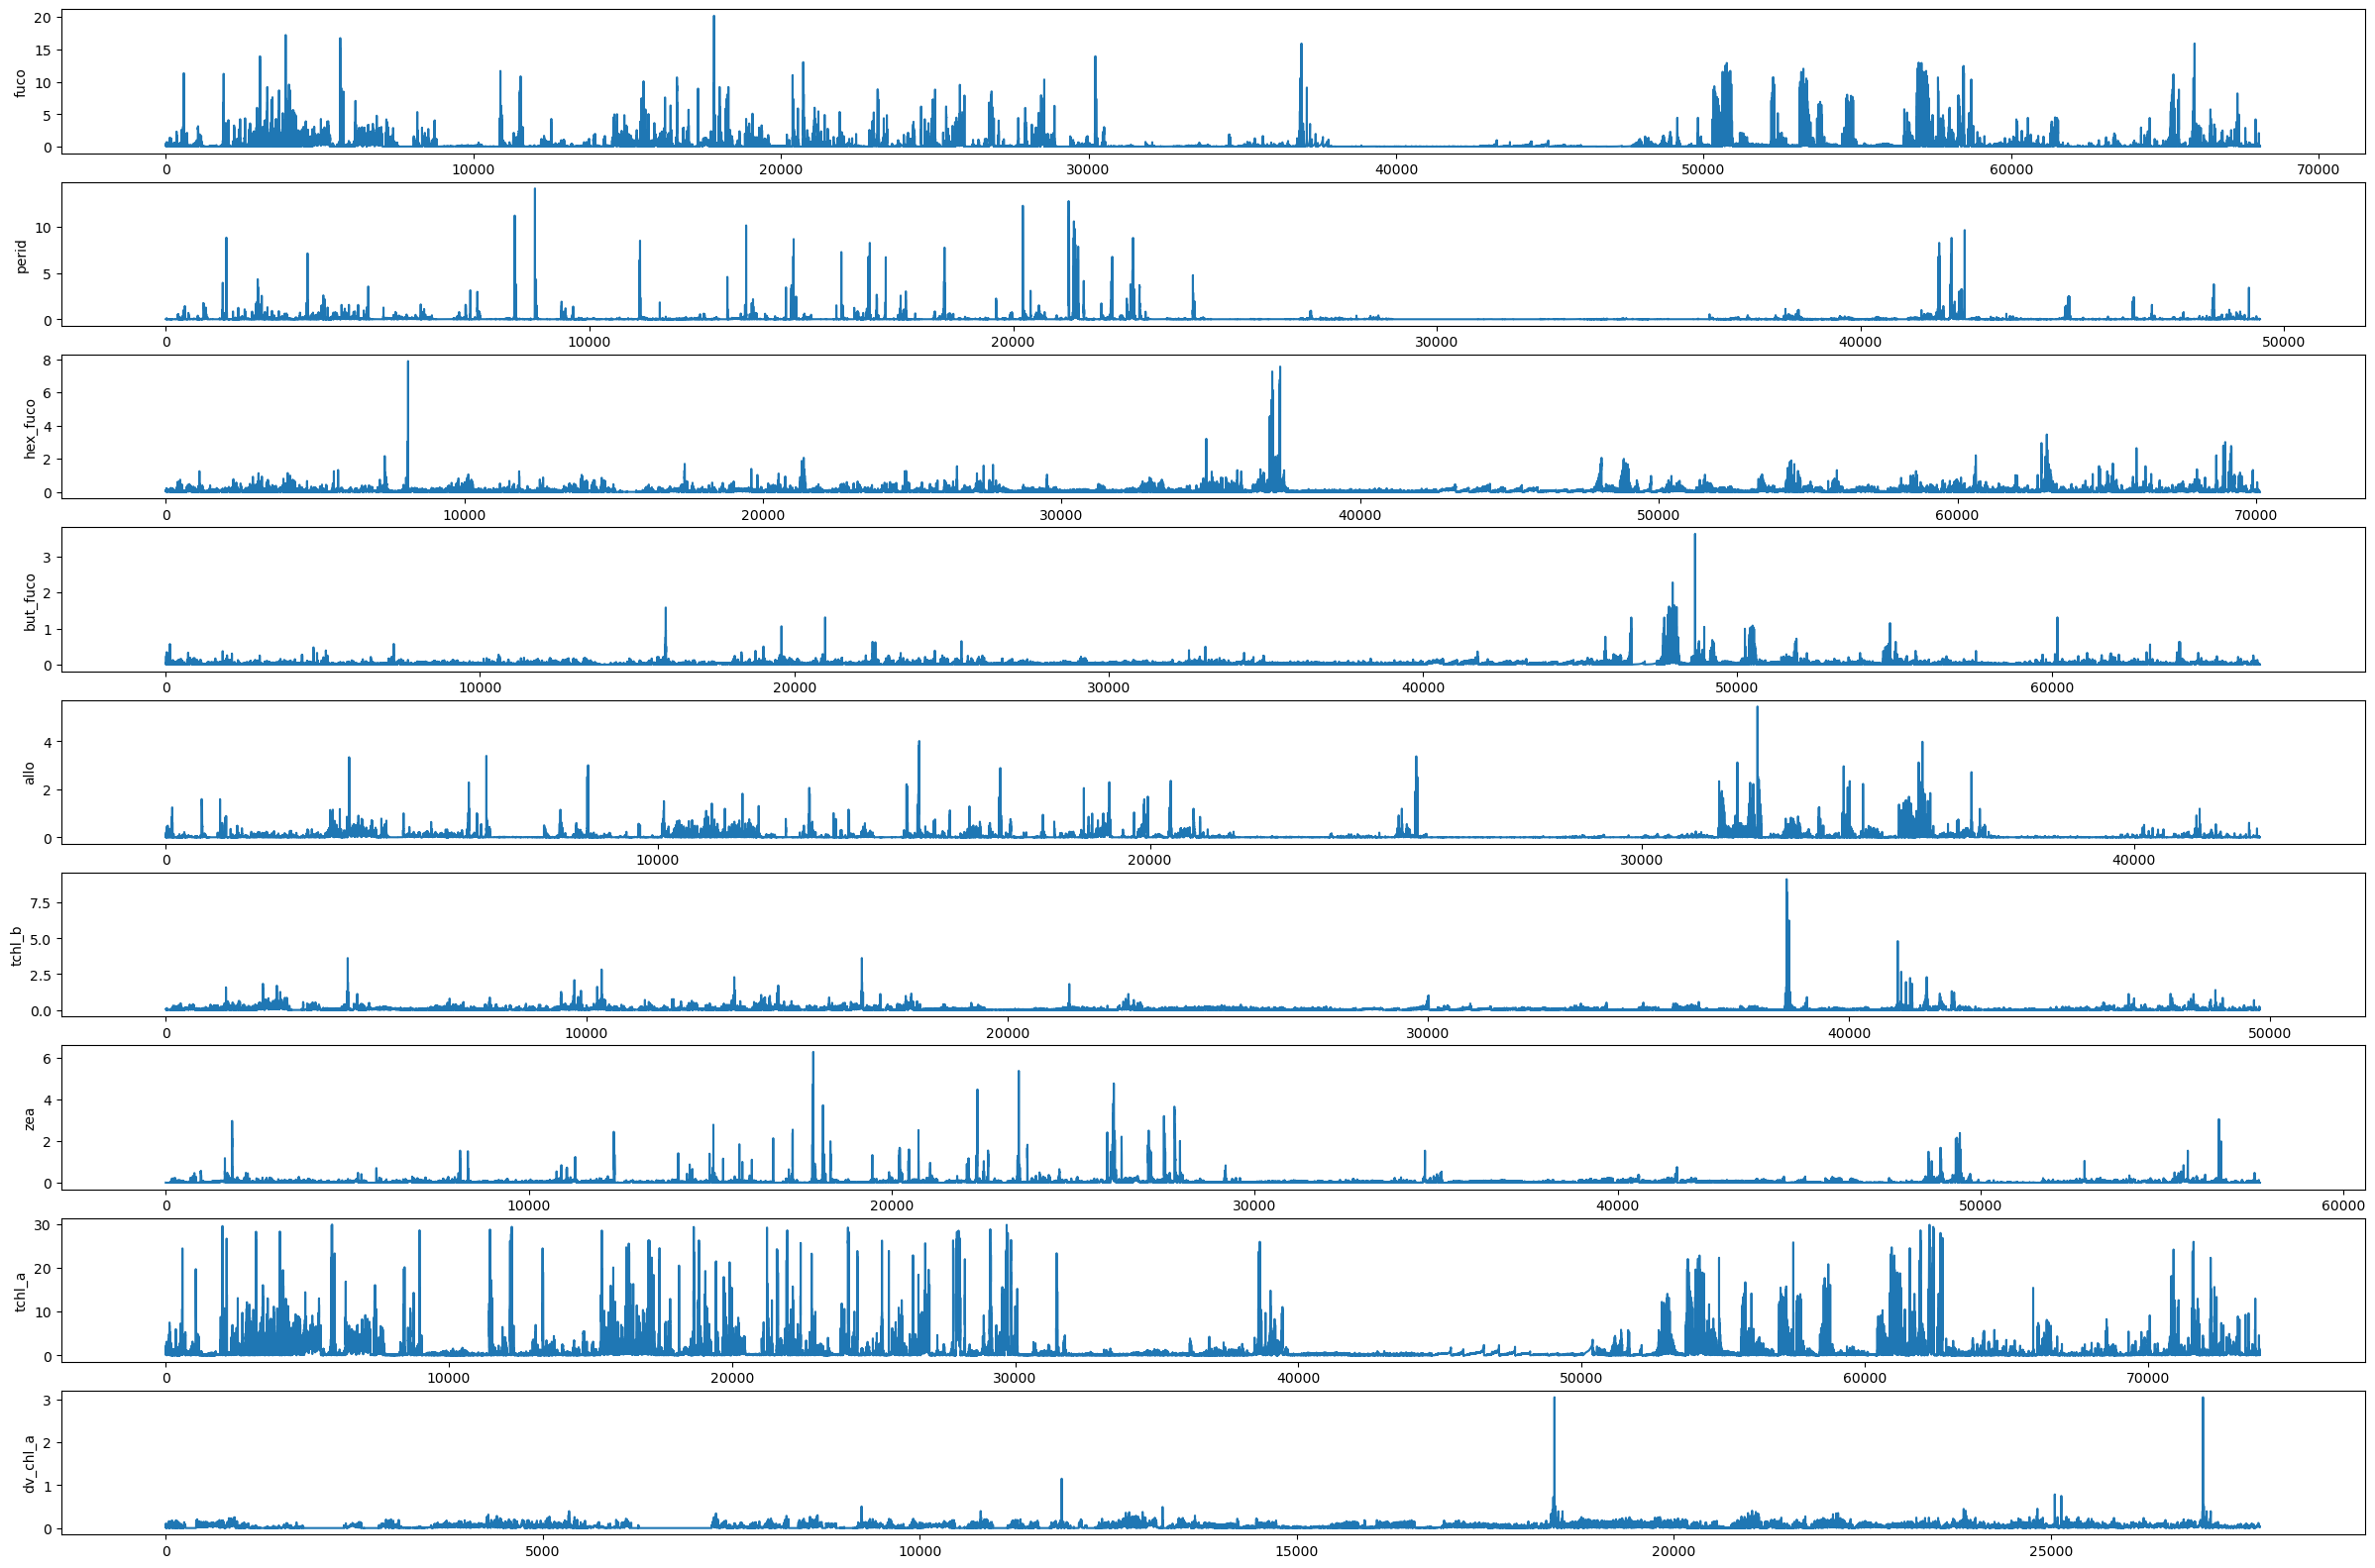

In [13]:
plt.figure(figsize=(30,20))
for i,var in enumerate(pigments):
    plt.subplot(len(pigments),1,i+1)
    plt.plot(pigments[var][use_pigments[var]])
    plt.ylabel(var)

<BarContainer object of 33 artists>

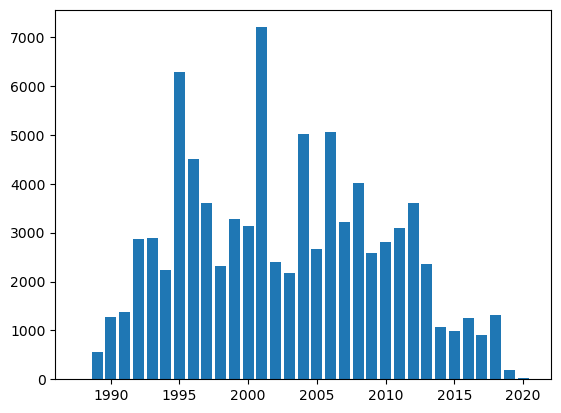

In [14]:
date_S = {str(y):0 for y in range(1988,2021)}
for d in dates:
    
    date_S[str(d.year)] +=1
ax = plt.axes()
plt.bar(np.arange(1988,2021),date_S.values())
# ax.xticklabels(np.arange(1988,2021))

In [15]:
# mark = []
# for d in dates:
#     if "{:0>4d}{:0>2d}{:0>2d}".format(d.year,d.month,d.day) not in mark:
#         mark.append("{:0>4d}{:0>2d}{:0>2d}".format(d.year,d.month,d.day))

In [16]:
# len(np.sort(mark))